<a href="https://colab.research.google.com/github/NewtoNLN/BootCamp-ML/blob/main/FAST_Aula_08_Deep_Neural_Networks_for_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

Deep Neural Networks for Computer Vision
==============================================

**Author**: `Pedro D. Marrero <https://pedrodiamel.github.io>`_

First, we need to install pytvision. The pytvision package consists of my datasets, models, and image transformations methods for computer vision projects. This package also containing the synthetic render methods. The backend transforms using opencv.

[pytVision](https://github.com/pedrodiamel/pytorchvision)





In [ ]:
%%shell
pip install -U 'git+https://github.com/pedrodiamel/pytorchvision.git@master#egg=pytvision'

  Cloning https://github.com/pedrodiamel/pytorchvision.git (to revision master) to /tmp/pip-install-ildk8u6g/pytvision_6f0e7e0baea846688699b91e2af1902a
  Running command git clone -q https://github.com/pedrodiamel/pytorchvision.git /tmp/pip-install-ildk8u6g/pytvision_6f0e7e0baea846688699b91e2af1902a
     |████████████████████████████████| 676 kB 4.1 MB/s 
     |████████████████████████████████| 432 kB 8.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Created wheel for pytvision: filename=pytvision-0.0.0-py2.py3-none-any.whl size=118477 sha256=75ae93ebb92786779e1c76e4783e69765ad3cdd96852727afe6ed2719ba8be2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-_az1pxf8/wheels/61/44/a7/a89e94156f4bbe688dbb7464f11ad533a495af3b0187f74ec0
  Created wheel for scikit-fmm: filename=scikit_fmm-2022.3.26-cp37-cp37m-linux_x86_64.whl size=221459 sha256=8d76fef

In [ ]:
from __future__ import print_function, division

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view
from pytvision.datasets.datasets  import Dataset
from pytvision.datasets.factory  import FactoryDataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


Image datasets analysis
---
https://www.cs.toronto.edu/~kriz/cifar.html 

### Load Data

We will use pytvision and torch.utils.data packages for loading the
data.

In [ ]:
pathname = '~/.datasets'
pathname = os.path.expanduser( pathname )
name_dataset = FactoryDataset.cifar10

print(pathname)
print(name_dataset)

/root/.datasets
cifar10


In [ ]:
dataloader = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.validation, 
        download=True ),
    num_channels=3,
    transform=transforms.Compose([
        mtrans.ToResize( (48, 48), resize_mode='squash', padding_mode=cv2.BORDER_REPLICATE ),
        mtrans.ToTensor(),
        mtrans.ToNormalization(),
        ])
    )

print(len( dataloader.data.classes ))
print( dataloader.data.class_to_idx )
print(len(dataloader))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.datasets/cifar10/cifar-10-python.tar.gz to /root/.datasets/cifar10
10
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
10000


### Data visualization

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
49


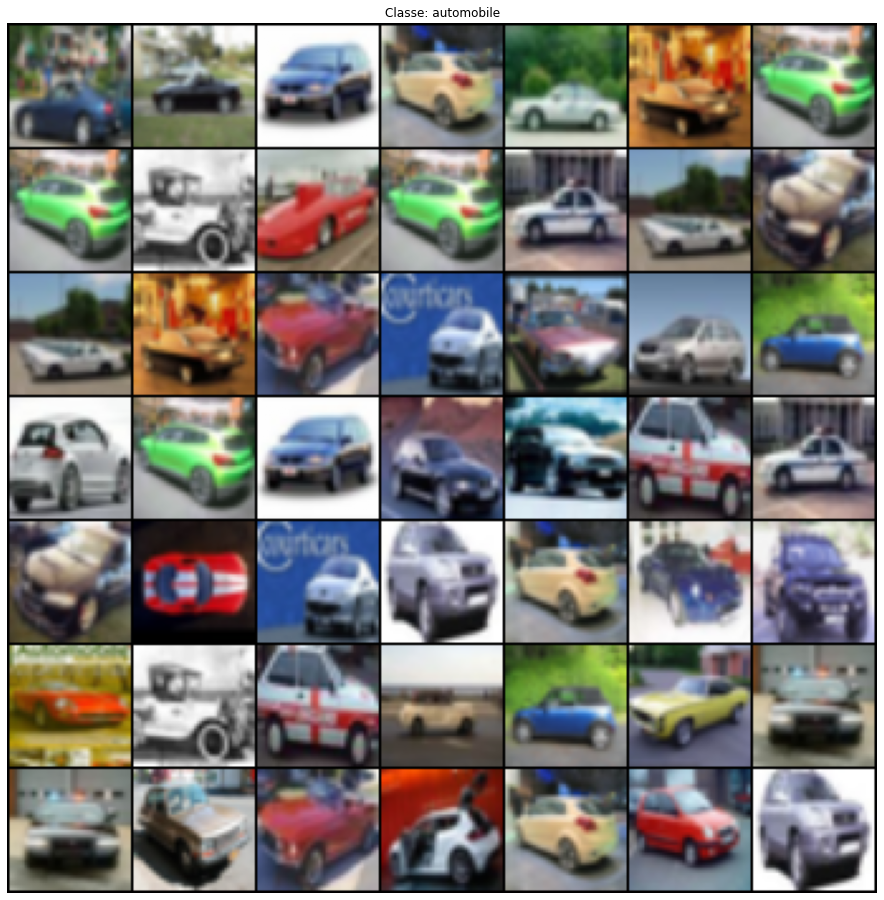

In [ ]:
num=48
classes_select = 1 # select class
dataloader_select = []
k=0
labels = dataloader.labels
imsize = 48

for i in range( len(dataloader) ):
    if labels[i] != classes_select: 
        continue        
    dataloader_select.append(dataloader[i]); k+=1
    if k > num: break;

n = len(dataloader_select)
print(dataloader.data.classes)
print(n)

plt.figure( figsize=(16,16))
view.visualizatedataset(dataloader_select, num=n, imsize=(imsize,imsize,3) )
plt.title('Classe: {}'.format( dataloader.data.classes[ classes_select ] ) )
plt.axis('off')
plt.ioff()
plt.show()

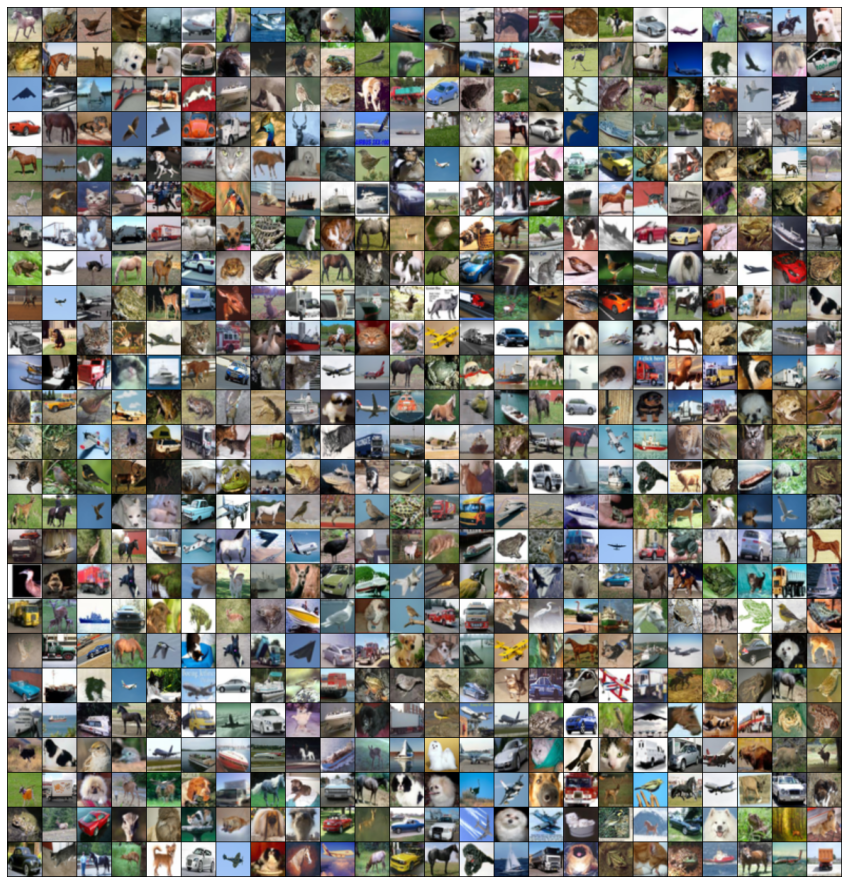

In [ ]:
plt.figure( figsize=(16,16))
view.visualizatedataset(dataloader, num=600, imsize=(imsize,imsize,3) )
plt.axis('off')
plt.ioff()
plt.show()

### Data augmentation

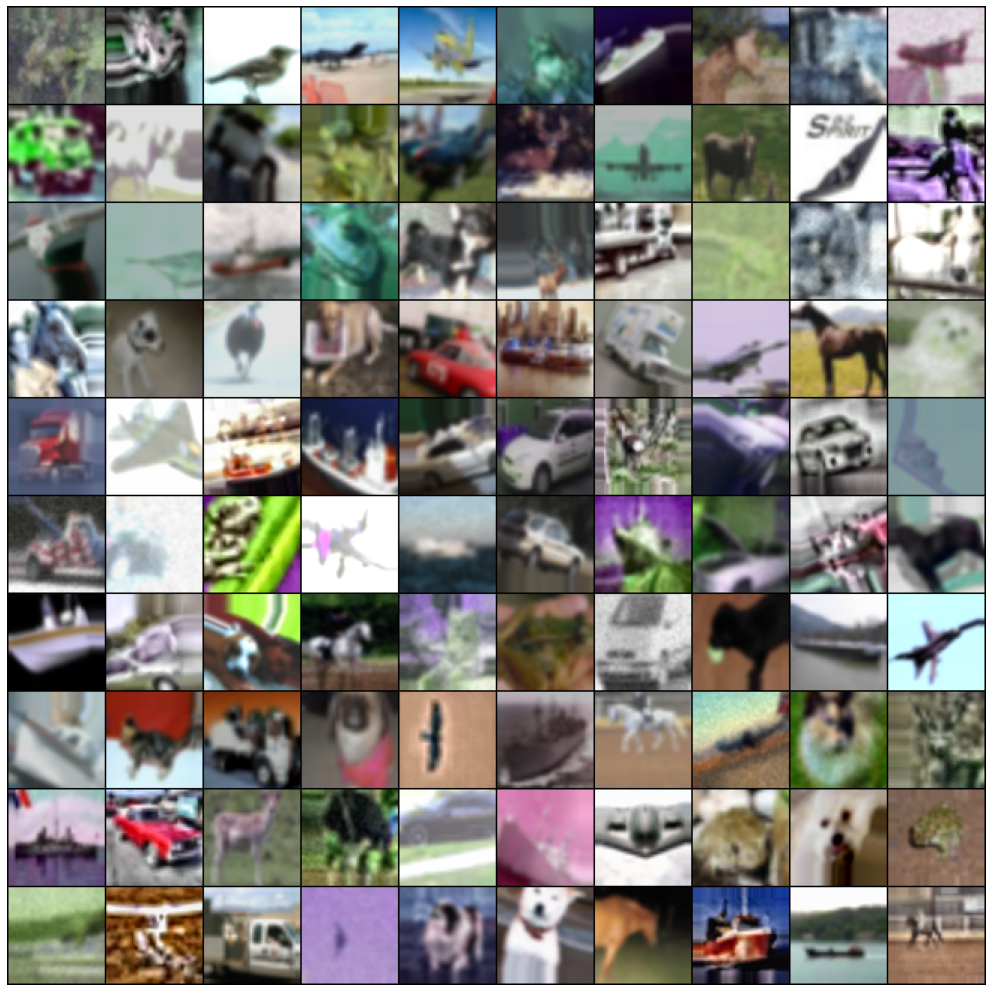

In [ ]:
size_input = 64

def transforms_aug( imsize ):
  return transforms.Compose([
        #------------------------------------------------------------------
        #Resize
        mtrans.ToResize( (size_input+5, size_input+5), resize_mode='square' ) ,
        mtrans.RandomCrop( (size_input, size_input), limit=2, padding_mode=cv2.BORDER_REPLICATE  ) ,
        
        #------------------------------------------------------------------
        #Geometric transform

        mtrans.RandomScale(factor=0.2, padding_mode=cv2.BORDER_REPLICATE ),
        mtrans.ToRandomTransform( mtrans.RandomGeometricalTransform( 
            angle=30, 
            translation=0.2, 
            warp=0.02, 
            padding_mode=cv2.BORDER_REPLICATE ), 
            prob=0.5 ),
        mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),
        #mtrans.ToRandomTransform( mtrans.HFlip(), prob=0.5 ),

        #------------------------------------------------------------------
        #Colors transform
        mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.25 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.25 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.25 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomRGBPermutation(), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.CLAHE(), prob=0.25 ),
        mtrans.ToRandomTransform(mtrans.ToGaussianBlur( sigma=0.05 ), prob=0.25 ),

        #------------------------------------------------------------------
        mtrans.ToTensor(),
        mtrans.ToNormalization()
        # cifar10 normalization
        # mtrans.ToMeanNormalization(
        #   mean = (0.4914, 0.4822, 0.4465),
        #   std  = (0.2023, 0.1994, 0.2010),
        # )                             

  ])


dataloader = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.validation, 
        #transform=train_transform, 
        download=False ),
    num_channels=3,
    transform=transforms_aug(size_input)
    )


plt.figure( figsize=(18,18) )
view.visualizatedataset(dataloader, num=100, imsize=(size_input,size_input,3), padding=1 )

plt.axis('off')
plt.ioff()
plt.show()

## Training and validation 

### Create model

https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html 


In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_classes=8, num_channels=1):
        super(AlexNet, self).__init__()

        self.num_classes = num_classes
        self.num_channels = num_channels
        self.size_input = 227
        self.dim = 256 * 6 * 6 # output layer of representation

        self.features = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1 )
        x = self.classifier(x)
        return x


model = AlexNet(num_classes=10, num_channels=3)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

### Parameters visualization 

torch.Size([64, 3, 11, 11])


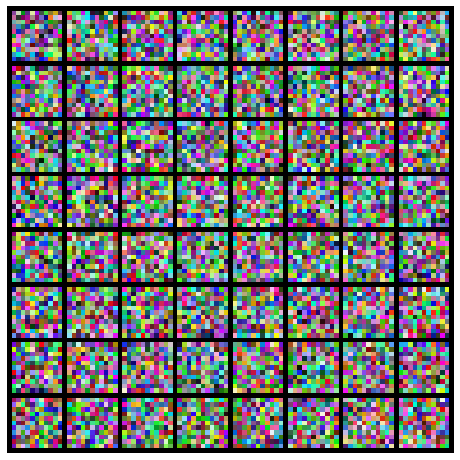

In [ ]:
ik = 0
kernel = model.features[ik].weight.data.clone()
print(kernel.shape)

view.vistensor(kernel, ch=0, allkernels=False)
#view.savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
from pytvision import logger as log
log.summary( model.cuda(), ( 3,224,224 ) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]           23296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]          307392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]          663936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]          884992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]          590080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

### Load dataset for training

In [ ]:

pathname = '~/.datasets'
pathname = os.path.expanduser( pathname )
name_dataset=FactoryDataset.cifar10
size_input=model.size_input

train_data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.validation, 
        download=True ),
    num_channels=3,
    transform=transforms.Compose([
        #------------------------------------------------------------------
        #Resize
        mtrans.ToResize( (size_input+5, size_input+5), resize_mode='square' ) ,
        mtrans.RandomCrop( (size_input, size_input), limit=2, padding_mode=cv2.BORDER_REPLICATE  ) ,
        
        #------------------------------------------------------------------
        #Geometric transform
        mtrans.RandomScale(factor=0.2, padding_mode=cv2.BORDER_REPLICATE ),
        mtrans.ToRandomTransform( mtrans.RandomGeometricalTransform( 
            angle=30, 
            translation=0.2, 
            warp=0.02, 
            padding_mode=cv2.BORDER_REPLICATE ), 
            prob=0.5 ),
        mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),

        #------------------------------------------------------------------
        #Colors transform
        mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.25 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.25 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.25 ), prob=0.50 ),
        #------------------------------------------------------------------
        mtrans.ToTensor(),

        # cifar10 normalization
        mtrans.ToMeanNormalization(
          mean = (0.4914, 0.4822, 0.4465),
          std  = (0.2023, 0.1994, 0.2010),
        )                         
        ])

    )

print('Size dataset: ', len(train_data))

num_train = len(train_data)
sampler = SubsetRandomSampler(np.random.permutation( num_train ) )
train_loader = DataLoader(
    train_data, 
    batch_size=30,
    sampler=sampler, 
    num_workers=1, 
    drop_last=True
    )



Files already downloaded and verified
Size dataset:  10000


### Loss function and metrics definition

In [ ]:

class TopkAccuracy(nn.Module):
    
    def __init__(self, topk=(1,)):
        super(TopkAccuracy, self).__init__()
        self.topk = topk

    def forward(self, output, target):
        """Computes the precision@k for the specified values of k"""
        
        maxk = max(self.topk)
        batch_size = target.size(0)

        pred = output.topk(maxk, 1, True, True)[1].t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in self.topk:
            # print(correct[:2].shape)
            # print(correct[:2].sum())
            # assert(False).view(-1) 0, keepdim=True
            correct_k = correct[:k].float().sum()            
            res.append( correct_k.mul_(100.0 / batch_size) )

        return res


loss_func = nn.CrossEntropyLoss()
metric_func = TopkAccuracy((1,5))


### Optimization

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.5)

### Training model 

In [ ]:
model = model.cuda()

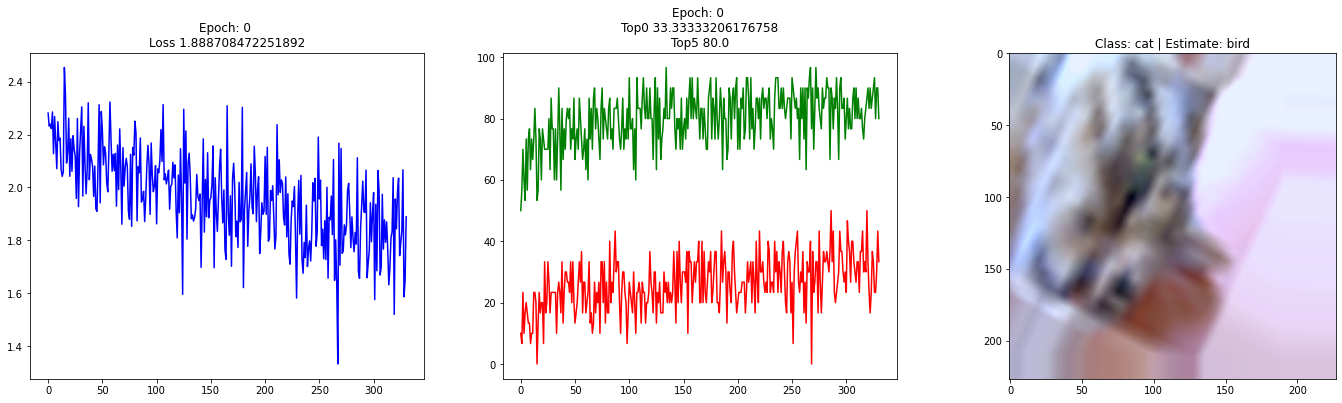

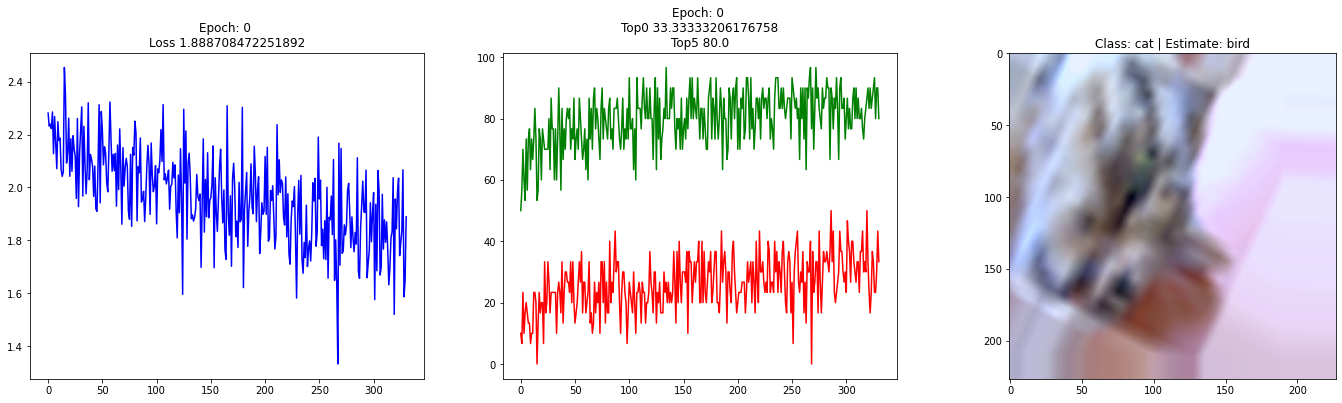

In [ ]:
import time
from IPython import display

def norm(x):
    x = x - x.min()
    x = x / x.max()
    return x

def fit( epochs, model, loss_func, metric_func, opt, dataset ):
  
  plt.figure(figsize=(24,6))
  errs = []
  top0 = []
  top5 = []  

  model.train()
  for iepoch in range(epochs):
    for i, sample in enumerate(dataset):      
      x, y = sample['image'], sample['label'].argmax(1).long()
      batch_size = x.size(0)

      # cuda
      xo, yo = x.cuda(), y.cuda()

      # fit (forward)
      yhat = model(xo)

      # measure accuracy and record loss
      loss = loss_func(yhat, yo.long())
      pred = metric_func(yhat.data, yo)

      errs.append( loss.data.item() )
      top0.append( pred[0].data.item() )
      top5.append( pred[1].data.item() )

      # optimizer
      opt.zero_grad()
      loss.backward()
      opt.step()

      if i % 10 == 0: 
        img = x[0,:,:,:].permute(1,2,0)
        label_est = train_data.data.classes[ torch.argmax(yhat[0,...]) ]
        label_org = train_data.data.classes[ y[0,...] ]

        plt.clf()
        plt.subplot(131)
        plt.plot(np.arange(len(errs)), errs, '-b' , label='J')
        plt.title('Epoch: {} \nLoss {}'.format(iepoch, errs[-1] ))
        plt.subplot(132)
        plt.plot(np.arange(len(top0)), top0, '-r' , label='Top0')
        plt.plot(np.arange(len(top5)), top5, '-g' , label='Top5')
        plt.title('Epoch: {} \nTop0 {}\nTop5 {}'.format(iepoch, top0[-1], top5[-1] ))

        plt.subplot(133)
        plt.imshow( norm(img) )
        plt.title('Class: {} | Estimate: {}'.format(label_org, label_est) )
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1.0)

      

fit( 1, model, loss_func, metric_func, optimizer, train_loader )

### Load ImageNet pretraining model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

classifier.6.weight dim model torch.Size([10, 4096]) vs dim checkpointtorch.Size([1000, 4096])
classifier.6.bias dim model torch.Size([10]) vs dim checkpointtorch.Size([1000])
torch.Size([64, 3, 11, 11])


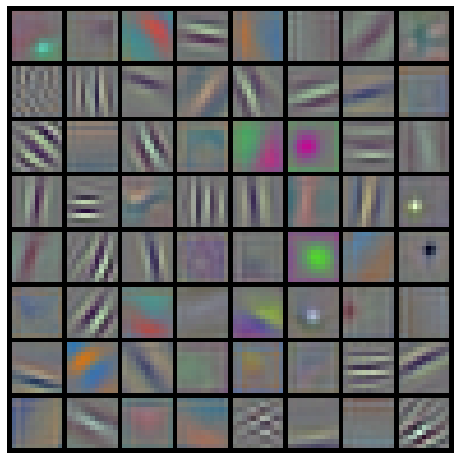

In [ ]:
import torch.utils.model_zoo as model_zoo

def load_state_dict(state_dict_des, state_dict_src):
    """
    Load model for match weight
    """
    own_state = state_dict_des
    for name, param in state_dict_src.items():
        if name in own_state:            
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            try:
                own_state[name].copy_(param)
            except Exception:
                print('{} dim model {} vs dim checkpoint{}'.format(name, own_state[name].size(), param.size()))

load_state_dict(model.state_dict(), model_zoo.load_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'))

ik = 0
kernel = model.cpu().features[ik].weight.data.clone()
print(kernel.shape)

view.vistensor(kernel, ch=0, allkernels=False)
#view.savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

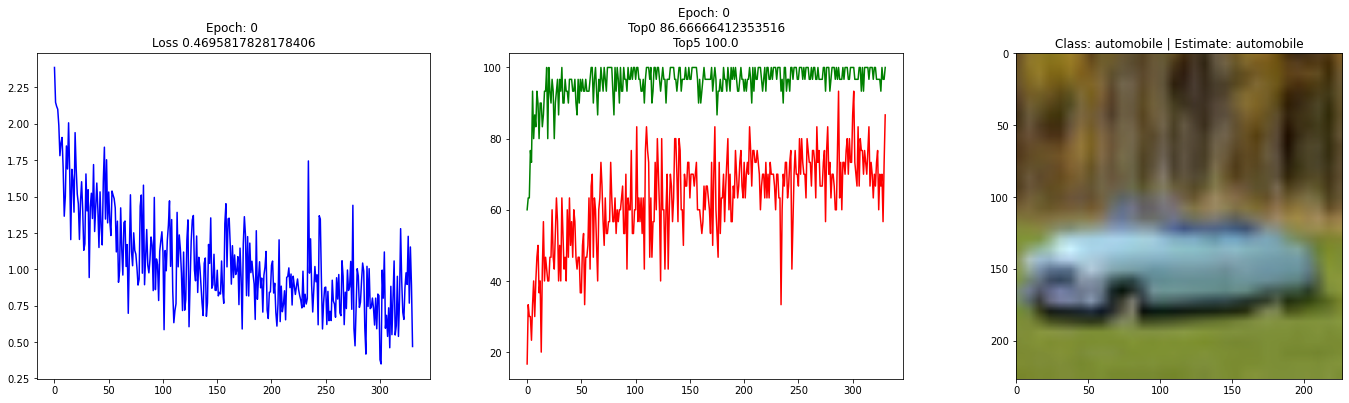

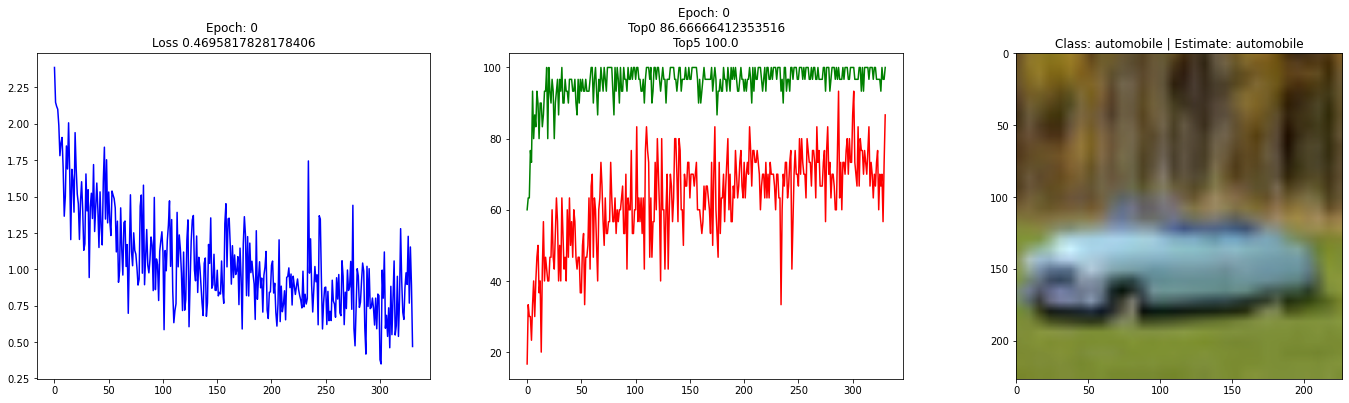

In [ ]:
model = model.cuda()
fit( 1, model, loss_func, metric_func, optimizer, train_loader )

### Save model

In [ ]:
# save training model
torch.save( {'state_dict': model.state_dict()},  'cls_model.zip' )

### Load model

In [ ]:
# load model for test
model = AlexNet(num_classes=10, num_channels=3)

model.cuda()
print(model)

checkpoint = torch.load( 'cls_model.zip' )
load_state_dict(model.state_dict(), checkpoint['state_dict'] )
print('Load model ...')


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

## Evaluation model

In [ ]:
import torch.nn.functional as F

def test(model, data):

    Yhat = []
    Y = []
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(tqdm(data)):

            # get data (image, label)
            x, y = sample['image'], sample['label'].argmax(1).long()
            x = x.cuda()

            # fit (forward)
            yhat = model(x)
            yhat = F.softmax(yhat, dim=1).argmax(dim=1)
            yhat = yhat.cpu().numpy()
            y = y.cpu().numpy()

            Yhat.append(yhat)
            Y.append(y)

    Yhat = np.hstack(Yhat)
    Y = np.hstack(Y)

    return Yhat, Y


In [ ]:
pathname = '~/.datasets'
pathname = os.path.expanduser( pathname )
name_dataset=FactoryDataset.cifar10
size_input=model.size_input

test_data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.test, 
        download=False ),
    num_channels=3,
    transform=transforms.Compose([
        #------------------------------------------------------------------
        #Resize
        mtrans.ToResize( (size_input, size_input), resize_mode='square' ) ,
        mtrans.ToTensor(),
        # cifar10 normalization
        mtrans.ToMeanNormalization(
          mean = (0.4914, 0.4822, 0.4465),
          std  = (0.2023, 0.1994, 0.2010),
        )                         
        ])

    )

print('Size dataset: ', len(test_data))

num_test = len(test_data)
test_loader = DataLoader(
    test_data, 
    batch_size=30,
    num_workers=1, 
    shuffle=False, 
    drop_last=False
    )


Size dataset:  10000


In [ ]:
Yhat, Y = test(model, test_loader)

100%|██████████| 334/334 [00:25<00:00, 13.05it/s]


In [ ]:
from sklearn import metrics

y, yhat = Y, Yhat

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro' )
recall = metrics.recall_score(y, yhat, average='macro' )
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")



Accuracy : 0.821600
Precision : 0.830297
Recall : 0.821600
F1 score : 0.825926



In [ ]:
metric = metrics.classification_report(y, yhat)
print(metric)

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1000
           1       0.89      0.94      0.91      1000
           2       0.90      0.71      0.79      1000
           3       0.66      0.73      0.69      1000
           4       0.87      0.73      0.79      1000
           5       0.77      0.79      0.78      1000
           6       0.72      0.94      0.82      1000
           7       0.83      0.85      0.84      1000
           8       0.89      0.89      0.89      1000
           9       0.85      0.92      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [ ]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[714  33  16  39  10  11   9  20  87  61]
 [  2 937   1   3   0   4   5   0   4  44]
 [ 20   2 712  48  42  37 110  18   6   5]
 [  1   2  16 731  15 113 100  13   6   3]
 [  4   1  17  55 726  20  93  82   2   0]
 [  0   0  10 129   8 794  24  33   0   2]
 [  0   2  10  38   6   5 938   0   1   0]
 [  5   2   8  52  24  44  10 848   0   7]
 [ 24  27   2   7   2   4   4   1 894  35]
 [  6  49   2   5   1   2   4   1   8 922]]


Normalized confusion matrix


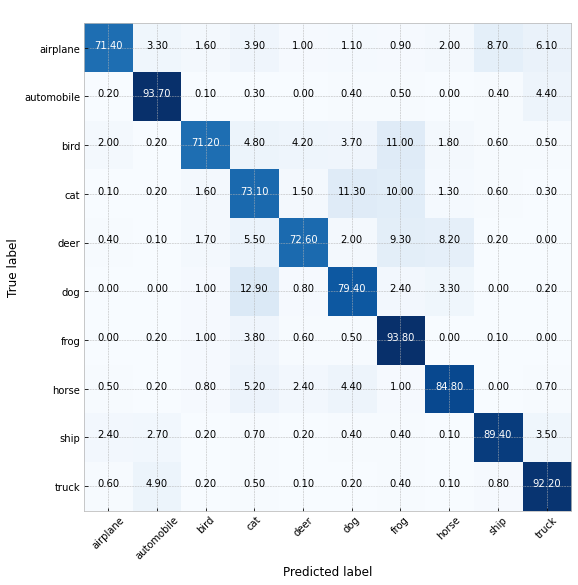

In [ ]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


matplotlib.style.use('bmh')
plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, test_data.data.classes, title=' ',  normalize=True)
plt.grid('off')
# plt.axis('off')
plt.show()

## Online test ...

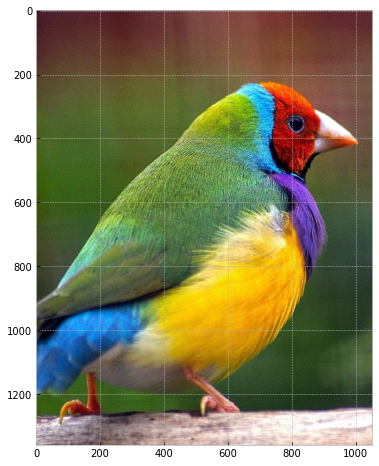

In [ ]:
from skimage import io
image = io.imread('https://images-na.ssl-images-amazon.com/images/I/71C-KgX7owL.jpg')

plt.figure( figsize=(8,8) )
plt.imshow(image)
plt.show()


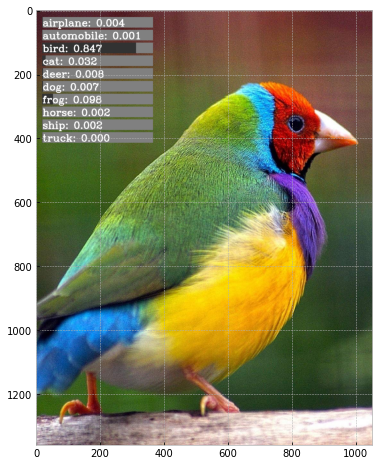

('bird', tensor(0.8474, device='cuda:0', grad_fn=<UnbindBackward0>))
Predict: 
----------------------------
airplane 0.3815
automobile 0.0665
bird 84.7391
cat 3.1832
deer 0.8088
dog 0.6570
frog 9.7946
horse 0.1600
ship 0.2003
truck 0.0090


In [ ]:
import operator
import cv2

def drawlabel(image, score, classes, imsize=(550,550)):
    
    colors = ([128,128,128],[128,128,128],[255,255,255],[0,255,0]);
    hbox=32; wbox=135 + 210;
    image_sh = image.copy() 
    image_sh = cv2.resize( image_sh, imsize )
    
    for i,(e,v) in enumerate(score.items()):
    
        bbox = np.array([[0,0],[wbox,0],[wbox,hbox],[0,hbox]]);    
        bbox[:,0] += 19
        bbox[:,1] += 50-28 + (i)*40
        im = cv2.fillConvexPoly(image_sh, bbox, color=colors[1] )
        
        bbox = np.array([[0,0],[int(wbox*v),0],[int(v*wbox),hbox],[0,hbox]]);    
        bbox[:,0] += 19
        bbox[:,1] += 50-28 + (i)*40
        im = cv2.fillConvexPoly(image_sh, bbox, color=[50,50,50] )
        
        cv2.putText(
                image_sh, 
                '{}: {:.3f}'.format(e,v), 
                (20, 50 + (i)*40), 
                color=colors[2], 
                fontFace=cv2.FONT_HERSHEY_COMPLEX, 
                fontScale=1, 
                thickness=2
                )
        
    return image_sh


def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

imsize=model.size_input
x = image
x = x.mean(axis=2)        
x = np.stack( (x,x,x), axis=2 )
x = cv2.resize( x, (imsize,imsize) )
x = torch.from_numpy(x).permute( (2,0,1) ).unsqueeze(0).float().cuda()
x = mean_normalization(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.eval()
yhat = model(x)
labelhat = F.softmax( yhat, dim=1 )[0,:]
score = dict(zip(test_data.data.classes, labelhat ))   
curremot = max(score.items(), key=operator.itemgetter(1)) 


plt.figure( figsize=(8,8)  )
plt.imshow( drawlabel(image, score, test_data.data.classes, imsize=( image.shape[1], image.shape[0] ) ) )
plt.show()

print(curremot)
print('Predict: ')
print('----------------------------')
for e,v in score.items():
    print(e, '{:.4f}'.format(v*100) )
